In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Load and view data

In [2]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

In [3]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


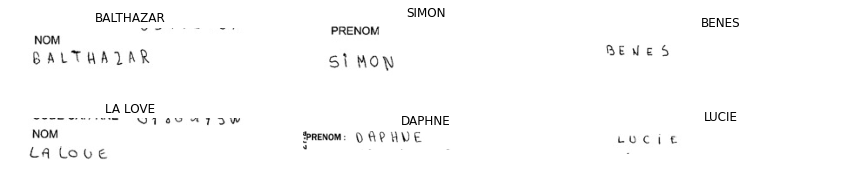

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

In [5]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set       : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in test set       :  70


In [6]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'.check those images and remove them.

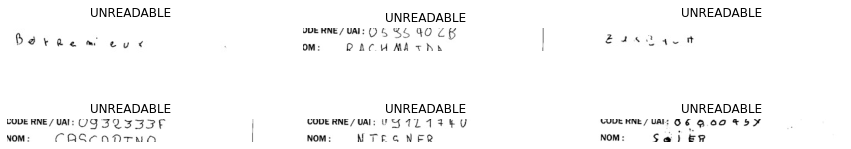

In [7]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [9]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

Reset the index and we are done with cleaning. 

In [10]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

In [11]:
train_y_labels_max=0
train_y_labels_sum=0
train_y_labels_count_freq={}
for i in range(len(train)):
    freq=len(train.loc[i,'IDENTITY'])
    if freq in train_y_labels_count_freq:
        train_y_labels_count_freq[freq]=train_y_labels_count_freq[freq]+1
    else:
        train_y_labels_count_freq[freq]=1
    if freq>train_y_labels_max:
        train_y_labels_max=freq
    train_y_labels_sum = train_y_labels_sum+freq

print('max len:', train_y_labels_max)
print('avg len:', train_y_labels_sum/len(train))


max len: 34
avg len: 6.546531272139367


<BarContainer object of 25 artists>

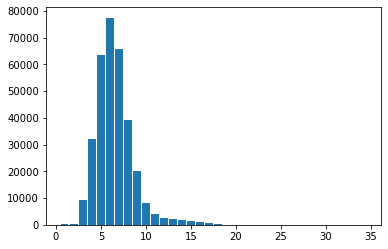

In [12]:
plt.bar(list(train_y_labels_count_freq.keys()),list(train_y_labels_count_freq.values()))

In [13]:
print(train_y_labels_count_freq)

{9: 20161, 5: 63637, 7: 65879, 6: 77412, 8: 39194, 4: 32015, 11: 4064, 12: 2615, 14: 1822, 15: 1468, 10: 8258, 13: 2058, 3: 9095, 16: 1201, 17: 521, 2: 441, 19: 85, 1: 125, 18: 211, 24: 1, 21: 11, 20: 12, 22: 5, 34: 1, 23: 2}


In [14]:
print('train:',len(train),'test:',len(test),'valid:',len(valid))

train: 330294 test: 41289 valid: 41280


In [15]:
train = train[train['IDENTITY'].str.len() < 20]
valid = valid[valid['IDENTITY'].str.len() < 20]
test = test[test['IDENTITY'].str.len() < 20]

In [16]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

In [17]:
print('train:',len(train),'test:',len(test),'valid:',len(valid))

train: 330262 test: 41284 valid: 41279


## Preprocessing and preparing the images for training

In [18]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

**Image Augmentation**

In [19]:
def augment_image(image):
    # Random Gaussian Blur
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)  # Horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)  # Vertical flip
        
    if np.random.rand() < 0.5:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)  # Ensure odd-sized kernel
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # Random Brightness Adjustment
    if np.random.rand() < 0.5:
        brightness_factor = np.random.uniform(0.7, 1.3)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random Contrast Adjustment
    if np.random.rand() < 0.5:
        contrast_factor = np.random.uniform(0.7, 1.3)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # Random Saturation Adjustment
    if np.random.rand() < 0.5:
        saturation_factor = np.random.uniform(0.7, 1.3)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # Extract the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]

    return image

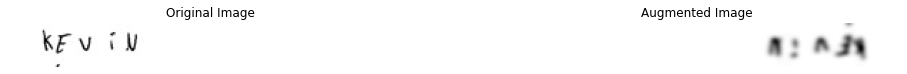

In [20]:
# Example usage
img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/TEST_0001.jpg'
img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
aug_img = augment_image(img)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_img, cmap='gray')
plt.title('Augmented Image')
plt.axis('off')

plt.show()

The model will be trained on 30000 images and validate on 3000 images

In [21]:
train_size = 40000
valid_size = 4000
test_size = 4000

In [22]:
img_aug_cnt=0

In [23]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    if random.randint(0, 8)==5:
        image= augment_image(image)
        img_aug_cnt=img_aug_cnt+1
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [24]:
img_aug_cnt

4361

In [25]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [26]:
test_x = []

for i in range(test_size):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [27]:
print('train:',len(train_x),'valid:',len(valid_x),'test:',len(test_x))

train: 40000 valid: 4000 test: 4000


In [28]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss


In [29]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 20 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [30]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [31]:
# aug_size= 5000

In [32]:
train_y = np.ones([train_size,max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [33]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [34]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY']) 

In [35]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [36]:
print("train_x:",len(train_x),"train_y",train_y.shape,"vaild_x:",len(valid_x),"valid_y:",valid_y.shape,"test_x:",len(test_x),"test_y:",test_y.shape)

train_x: 40000 train_y (40000, 20) vaild_x: 4000 valid_y: (4000, 20) test_x: 4000 test_y: (4000, 20)


**augmentation**

In [37]:
# train_size=40000
# for i in range(aug_size):
#     random_number = random.randint(0, train_size-1)
#     img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[random_number, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     image = augment_image(image)
#     image = preprocess(image)
#     image = image/255.
#     ran_num_label = train_y[random_number]
#     ran_label_len = len(train.loc[random_number, 'IDENTITY'])
#     index = train_size+i
#     train_x.append(image)
#     train_label_len[index] = len(train.loc[random_number, 'IDENTITY'])
#     train_y[index, 0:len(train.loc[random_number, 'IDENTITY'])]= label_to_num(train.loc[random_number, 'IDENTITY'])    
#     print(train_y.shape,train_label_len.shape)

In [38]:
print(len(train_x))

40000


In [39]:
# from sklearn.utils import shuffle
# train_x = np.array(train_x)
# train_y = np.array(train_y)
# train_x, train_y = shuffle(train_x,train_y)

In [40]:
print('train:',train_x.shape,'valid:',valid_x.shape,'test:',test_x.shape)

train: (40000, 256, 64, 1) valid: (4000, 256, 64, 1) test: (4000, 256, 64, 1)


## Building our model


In [88]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.4)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.4)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 256, 64, 32)       128       
_________________________________________________________________
activation_18 (Activation)   (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 32, 64)     

In [42]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [89]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [90]:
print(train_x.shape, train_y.shape, train_input_len.shape, train_label_len.shape)

(40000, 256, 64, 1) (40000, 20) (40000, 1) (40000, 1)


## Train our model

In [91]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=64)
# ,callbacks=[early_stopping]

Epoch 1/60
625/625 [==============================] - 53s 84ms/step - loss: 21.6957 - val_loss: 20.0608
Epoch 2/60
625/625 [==============================] - 51s 82ms/step - loss: 19.6752 - val_loss: 19.2560
Epoch 3/60
625/625 [==============================] - 51s 82ms/step - loss: 17.7260 - val_loss: 16.6200
Epoch 4/60
625/625 [==============================] - 51s 82ms/step - loss: 13.7186 - val_loss: 10.1036
Epoch 5/60
625/625 [==============================] - 51s 82ms/step - loss: 9.7209 - val_loss: 6.6933
Epoch 6/60
625/625 [==============================] - 51s 82ms/step - loss: 7.6811 - val_loss: 5.1037
Epoch 7/60
625/625 [==============================] - 51s 82ms/step - loss: 6.6357 - val_loss: 4.3059
Epoch 8/60
625/625 [==============================] - 51s 82ms/step - loss: 5.9239 - val_loss: 3.7207
Epoch 9/60
625/625 [==============================] - 51s 82ms/step - loss: 5.4164 - val_loss: 3.3399
Epoch 10/60
625/625 [==============================] - 51s 81ms/step - los

## Check model performance on validation set

In [93]:
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

In [94]:
y_true = test.loc[0:test_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 89.31%
Correct words predicted      : 76.10%


## Some predictions on test set

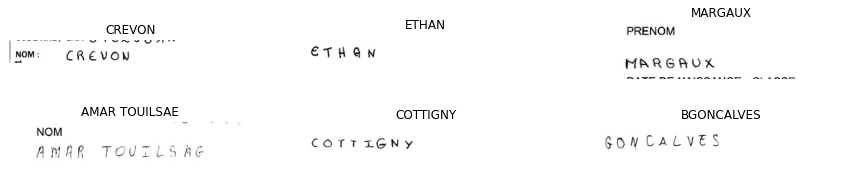

In [95]:
# test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(35000,35006):
    ax = plt.subplot(2, 3, i-35000+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

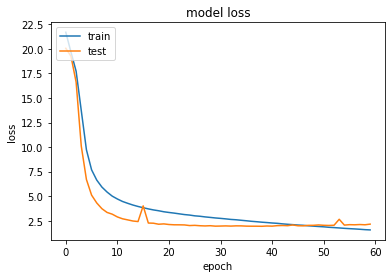

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [100]:
model_final.save('version_best.keras')

In [99]:
model.save('v.keras')